# Project execution example

The 2014 *Alice Corp. v. CLS Bank International* Supreme Court decision [573 U.S. 208 (2014)] (*Alice* decision) weakened the enforceability of existing software patents and limited the patentability of new software-related innovations.  I introduce a novel approach that directly uses the patent claim language of patent applications that were rejected due to the *Alice* decision to train a binary natural language processing (NLP) classification algorithm and identify claim language that is not eligible after *Alice* anymore.  The advantage of this method is that I can predict for a large set of patents whether they are invalid and identify treated firms by measuring the share of invalid patents in patent portfolios before the *Alice* shock.  

This notebook is a walkthrough of the Alice patent classification project from the definition of the training data and fitting of the NLP models to the classification of patent claims of exisiting patents.  The methods for each step are in the patent_classification_project package.  The different modules of the package are also executable files and contain beside a main method also other useful comments and code variations. 

The models and steps in this file below build up on each other.  The sequence of the execution is as follows:
1) **claim_text_extractions_for_training.py**: load patent application texts from USPTO websites that are related to rejected applications due to Alice and control texts from patents in same class and cohort.
2) **training_data_build.py**: uses the downloaded application and patent texts to prepare training data for the NLP model fitting.
3) **NLP_model_building.py**: build, fit, and evaluate the NLP classification model to estimate whether a patent claim text is invalid after *Alice*.
4) **patent_claim_classification.py**: classify claim texts of issued patent in PatentsViews whether they are invalid after *Alice*.

The package also contains the method **application_pregrant_pub_claim_classification.py** which uses the trained NLP model to classify claim texts of application pre-grant publications in PatentsView.

The module **classification_testing.py** is an optional program file that I run as the last step in this file to test that the classification method indeed performs better than using just CPC groups to identify patents that are likely invalid after *Alice*.  The module loads the classification outcomes and defines a patent as treated if the first claim is classified as invalid.  The first claim of a patent is ususally the broadest in the patent and thus deterimnes the overall scope of the patent.  I then plot the patent issuances for treated and untreated patents over time and run several difference-in-differences regression models that show how patents classified as invalid are indeed less likely to be issued after *Alice*.

The methods that load claim texts from USPTO sites and classify the text can be run parallel since PatentsView has separate files for respective pre-grant publication and issue years.  In the current modules of the package, I commented out the parallel version since I will run the files on my local desktop machine.  The parallel methods are most useful on servers when classifying many more patents than in this example.  

The package also contains the working directory for the project.  In the working directory, relevant downloaded patent data, as well as the classification outputs and the analysis outputs such as wordclouds and performance reports for NLP models are saved.  The storage space required can become quite big (for example, my local working directoy take up almost 40 GB).  Especially the 'PatentsView_raw_data' folder can take up a lot of space since large data files with patent information are downloaded from PatentsView (https://patentsview.org/download/data-download-tables) and stored here.  

If storage limitation are a concern, limit the executions to only the variants of the patent classification that are truly needed.  You can also adjust the code to store only relevant information such as CPC-based classications instead of both USPC and CPC-based.  Finally, to really save storage space, pre-download the relevant patent information from PatentsView, edit the data file to only include the needed columns, and adjust the code to load only the pre-edited PatentsView data.   

For this project, all data are sourced from the United States Patent and Trademark Office (USPTO), www.uspto.gov, and PatentsView, https://patentsview.org/download/data-download-tables.  Especially the research datasets release by the Office of the Chief Economist of the USPTO, www.uspto.gov/ip-policy/economic-research/research-datasets, are valuable sourced for this project.  The Patent Examination Research Dataset (PatEx), www.uspto.gov/ip-policy/economic-research/research-datasets/patent-examination-research-dataset-public-pair, is the source for application data.  The Office Action Research Dataset for Patents, www.uspto.gov/ip-policy/economic-research/research-datasets/office-action-research-dataset-patents, is the source for office actions and rejection data.  The Office Action Research Dataset is based on the research in Lu, Qiang and Myers, Amanda F. and Beliveau, Scott, USPTO Patent Prosecution Research Data: Unlocking Office Action Traits (November 20, 2017). USPTO Economic Working Paper No. 2017-10.

Research data from the USPTO website are in the public domain, and PatentsView data are licensed under a Creative Commons Attribution 4.0 License.

## 0) Setup

Before the actual execution of the project, we load some useful packages and define the home directory.  As noted above, the project is quite storage intensive and can use up more than 30GB.

In the rest of the script, I removed for readability code segments that load PatentsView data and USPTO data from the website.  I assume those are already downloaded and in the right folders.  The relevant request and unzipping methods are in the underlying code modules. 

In case of an error, check the method files.  The URLs and the structure of the data on the USPTO websites sometimes changes which can cause issues.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import re
import os

import zipfile
import csv

import pickle
import joblib
import json

import seaborn as sns
import matplotlib.pyplot as plt

from IPython import display

import statsmodels.formula.api as sm
from statsmodels.formula.api import poisson
from statsmodels.formula.api import negativebinomial
from linearmodels import PanelOLS    

# For readability, disable also warnings
import warnings
warnings.filterwarnings('ignore') 

# Expand field limit to iterate through all claims
import ctypes
csv.field_size_limit(int(ctypes.c_ulong(-1).value // 2))
csv.field_size_limit()

# Define the home directory.  For this walkthrough, relevant subfolders are already created
home_directory = os.getcwd()
home_directory = 'working directory' #-> change this to the working directory you want to work in
os.chdir(home_directory)

# Define name of the directoy which stores raw data from PatentsView
PatentsView_directory = 'PatentsView_raw_data'

# Define the directory for all USPTO data that are not from PatentsView
USPTO_data_directory = 'USPTO_raw_data'
# Note: to save time, both of these subfolders were already created and populated with the relevant data

# Set seed
RANDOM_SEED = 42

The 'home_directory' is the path where the data and model outputs are stored.  In this example, I set it to 'working directory', if the files are run individually, the default is the current working directory.  Note again that the size of the folder can become very large.

As mentioned earlier, I assume the two folder with raw data, 'PatentsView_directory' and 'USPTO_data_directory', exist already as subfolders of the 'home_directory'.  I recommend downloading the relevant data from PatentsView and the USPTO research datasets before and unpacking them into these two folder before running the program.  The list of relevant data files is below:

- *USPTO_raw_data* - Folder with all relevant [USPTO research datasets](https://www.uspto.gov/ip-policy/economic-research/research-datasets):
  - *application_data_2017.csv* - [2017 vintage PatEx application research data](https://bulkdata.uspto.gov/data/patent/pair/economics/2017/application_data.csv.zip).
  - *application_data_2020.csv* - [2020 vintage PatEx application research data](https://bulkdata.uspto.gov/data/patent/pair/economics/2020/application_data.csv.zip), this dataset should be downloaded manually!
  - *office_actions_uspto_research_2017.csv* - [office action research dataset](https://bulkdata.uspto.gov/data/patent/office/actions/bigdata/2017/office_actions.csv.zip).
  - *rejections_uspto_research_2017.csv* - [rejections in office action research dataset](https://bulkdata.uspto.gov/data/patent/office/actions/bigdata/2017/rejections.csv.zip).
- *PatentsView_raw_data* - Folder with relevant [data table from PatentsView](https://patentsview.org/download/data-download-tables).
  - *application_pregrant_publication.tsv* - [published application data](https://s3.amazonaws.com/data.patentsview.org/pregrant_publications/pg_published_application.tsv.zip).
  - *cpc_current_PatentsView.tsv* - [current CPC classifications of granted patents](https://s3.amazonaws.com/data.patentsview.org/download/g_cpc_current.tsv.zip).
  - *cpc_current_pregrant_publication.tsv* - [current CPC classification data for all applications](https://s3.amazonaws.com/data.patentsview.org/pregrant_publications/pg_cpc_at_issue.tsv.zip).
  - *patent.tsv* - [data on granted patents](https://s3.amazonaws.com/data.patentsview.org/download/g_patent.tsv.zip), this file is optional and only used for the classification testing.
  - *uspc_current_PatentsView.tsv* - [current USPC classification for granted patents](https://s3.amazonaws.com/data.patentsview.org/download/uspc_current.tsv.zip), this is a legacy file and probably will not be available forever, replace it with [uspc_at_issue](https://s3.amazonaws.com/data.patentsview.org/download/g_uspc_at_issue.tsv.zip) if needed.
  - *uspc_pregrant_publication.tsv* - [current USPC classification published applications](https://s3.amazonaws.com/data.patentsview.org/pregrant_publications/pg_uspc_at_issue.tsv.zip), similar as above this is a legacy file and my need to be replace by [uspc_at_issue](https://s3.amazonaws.com/data.patentsview.org/pregrant_publications/pg_uspc_at_issue.tsv.zip).

Note that in the rest of the script the text loading and classification methods are executed linearly.  In the underlying modules, the methods have parallel versions in comments.  I recommend only executing these methods parallel on a Linux servers with fewer resource restriction in terms of memory and storage.  For debugging, linear version are useful, as well as for executions on desktop computers with more resource constraints. 

## 1) Load claim texts for model training

The first step of the project load claim texts of applications that were rejected due to *Alice* and control text of issued patents from the same USPC and filing years as reject application.  

In [3]:
from PyPatentAlice import claim_text_extractions_for_training

# Set module shared parameters in local namespace
claim_text_extractions_for_training.home_directory = home_directory
claim_text_extractions_for_training.PatentsView_directory = PatentsView_directory
claim_text_extractions_for_training.USPTO_data_directory = USPTO_data_directory
claim_text_extractions_for_training.RANDOM_SEED = RANDOM_SEED

I limit in this example to applications publications in the years 2013 and 2014, thus in the year of the *Alice* decision and the year prior.  This means that application texts, which are usually published within 18 months of the filing date, are very recent and not adjusted for by the application following the decision.

In [4]:
min_year_training_data = 2013
max_year_training_data = 2014

# Define output path
output_path = 'claim_extraction'

if not os.path.exists(output_path):
    os.makedirs(output_path)

I use Office Action Research Dataset for Patents data from the USPTO, based on Lu et al. (2017) to find applications that mention the *Alice* decision as reason for rejection.  This provides a list of pre-grant publication IDs of reject applications that are the basis for the the treated sample of texts.

There are several other court decision prior to *Alice* that also changed the patentability of certain inventions.  The research dataset also identifies rejectsion related to the *Bilski*, *Mayo*, and *Myriad* decision.  My project can be used to also classify patents for each or all of these events, but I restrict here to rejections due to *Alice*.

In [5]:
# Use office action research dataset from Chief Economist of USPTO to indentify treated applications
# source: https://www.uspto.gov/learning-and-resources/electronic-data-products/office-action-research-dataset-patents
rejections = pd.read_csv(USPTO_data_directory 
                         + '/rejections_uspto_research_2017.csv', low_memory=False)

#----------------------------------------
# Data on application in Patent View
application = pd.read_csv(
    PatentsView_directory + '/application_pregrant_publication.tsv', 
    delimiter="\t", quoting=csv.QUOTE_NONNUMERIC, low_memory=False)

application['document_number'] = application.pgpub_id
application['app_id'] = pd.to_numeric(application.application_id,
                                        downcast = 'integer', errors = 'coerce')
application['filing_date_dt'] = pd.to_datetime(application['filing_date'], 
                                               errors='coerce')
application['filing_year'] = application.filing_date_dt.dt.year

#===================================
# Define rejections due to Alice
alice_condition = (rejections.alice_in == 1)
alice_rejections = rejections[alice_condition].copy()

Control texts are from published patents in PatentsView from the same filing years and USPC classes as the rejected applications.  The method also downloads pre-grant publications of applications from the same filing-USPC class cohort wihtout office actions that were eventually granted.  These pre-grant publications are arguably even more comparable to the treated pre-grant claims and we can vary the classification method to use those text instead of the text of the issued control patents.  

In [6]:
print('Start control Claim Full Text extraction for Alice only')

claim_text_extractions_for_training.control_patent_claim_fulltext_extraction(
    rejections_data=alice_rejections,
    application=application,
    nclasses=50,
    output_path=output_path,
    min_year=min_year_training_data,
    max_year=max_year_training_data,
    output_name='Alice')

Start control Claim Full Text extraction for Alice only
	 Load relevant data
	 Control patent contruction
	USPC main classes in rejections:
705    33797
463     3835
702     2565
709     2231
707     1272
701     1229
726     1190
435      981
434      911
704      850
Name: uspc_class_str, dtype: int64
	 Number of extractable control applications from PatentsView Pre-grant applications: 297194
	 Start control claim extraction from PatentsView Pre-grant application for Alice and year 2013

	 Search application claims for year 2013
	 Lenght of output DF of independent application claims for type PatentsView_PregrantApp_ControlPatents_Alice, year 2013: 44219
	 Start control claim extraction from PatentsView Pre-grant application for Alice and year 2014

	 Search application claims for year 2014
	 Lenght of output DF of independent application claims for type PatentsView_PregrantApp_ControlPatents_Alice, year 2014: 49326
	 Number of extractable control patent from PatentsView: 464418
		 N

In [7]:
print('Start rejected Claim Full Text extraction for Alice only')

# Coerce to app_id to integer => all relevant app_ids are digits
alice_rejections['app_id_int'] = pd.to_numeric(alice_rejections.app_id, 
                                               downcast = 'integer', errors = 'coerce')


# Find document numbers from PatentsView Pre-grant application data
alice_rejections_application_with_doc_num = application[
    application.app_id.isin(list(alice_rejections.app_id_int))][
        ['app_id', 'document_number', 'filing_date_dt', 'filing_year']].drop_duplicates()

print('\t Number of extractable application with rejections by Alice only: '\
      + str(len(alice_rejections_application_with_doc_num)), flush=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Linear Execution
for year in range(min_year_training_data, max_year_training_data+1):
    print('\t Start rejected claim extraction for Alice only for year '\
          + str(year) + '\n')
    claim_text_extractions_for_training.application_claim_PatentView(
        year=year,
        app_df=alice_rejections_application_with_doc_num,
        output_path=output_path,
        output_name='Alice')                        

Start rejected Claim Full Text extraction for Alice only
	 Number of extractable application with rejections by Alice only: 35287
	 Start rejected claim extraction for Alice only for year 2013

	 Search application claims for year 2013
	 Lenght of output DF of independent application claims for type Alice, year 2013: 21401
	 Start rejected claim extraction for Alice only for year 2014

	 Search application claims for year 2014
	 Lenght of output DF of independent application claims for type Alice, year 2014: 33946


## 2) Build training data for model fitting

Next, we structure the downloaded treated and control claim text data to a data frame that can be used for model fitting.  The method also provides the main USPC classes of treated applaction, that is the four primary USPC classes that are most frequent among applications rejected due to *Alice*.

In [8]:
from PyPatentAlice import training_data_build

# Set module shared parameters in local namespace
training_data_build.home_directory = home_directory
training_data_build.PatentsView_directory = PatentsView_directory
training_data_build.USPTO_data_directory = USPTO_data_directory
training_data_build.RANDOM_SEED = RANDOM_SEED

The method cleans the data by, for example, ensuring the treated applications are really rejections due to *Alice*, removing cancelled claims from the data, and that control claim texts are from patents published after the *Alice* decision.  The training data then are restricted to the top four USPC classes in rejection data.  These four USPC classes account for ca, 91% of all rejected applications due to *Alice*.  


To balance the training data, control texts are drawn proportionally to the USPC class and filing year distribution as in the treated claim data.  If there are too few control claim texts in the data, which can happen when using pre-grant publications as control texts, the method can also resample the control claims with replacement.

In [9]:
model_data, uspc_main_category = training_data_build.training_data_import(
    nclasses=4,
    home_directory=os.getcwd(),
    specified_uspc_class=['xxx'],
    use_specified_uspc_class=False,
    text_source='claim_extraction',
    replacement=False,
    Issued_patent_control=True)


# Save the model data and the main categories as .pkl files
model_data.to_pickle('model_data_issued_patents_control.pkl')

with open('main_classes_issued_patents_control.pkl', 'wb') as fp:
    pickle.dump(uspc_main_category, fp)

		 Number of Alice Rejections Raw 56709
		 Number of Alice Rejections with no other injections 8090
		 Number of unique application ids with Alice Rejections with no other injections 5785
		 Number of Alice Treated independent claims 8303
		 Number of unique application ids with Alice Treated independent claims 2396
		 Number of treated claims from the right pre-grant publication document 8301
		 Number of treated claims from abandoned application status 3322
		 Number of treated claims purged for illogical dates 3320
		 Number of uncancelled treated claims 3276
	 Use for control claim construction the PatentsView claim texts
		 Number of control claims from PatentsView 1228449
 	 Alice unique treated claims before class selections: 
2196
 	 Unique control claims before class selections: 
1227488
		 Count of Alice classes
705    1640
463     235
702     104
434      45
703      15
704      15
709      14
707      13
273      11
708      11
Name: uspc_class_str, dtype: int64
		 Cumsum o

As the statistics show, the most affected USPC class is '705'.  This is consistent with the literature and sometimes used as identification for *Alice* affected patents.  However, it is not the only affected class, and CPC groups do not translate easily into USPC classes.  Using this class alone thus would not be enough to identify longrun effects.

Note that file-paths include 'issue_patent_control' in the name from here on out to signal that issued patent claims from PatentsView are used as control claims.

In [10]:
# Clean up some memory before continuing
del application, alice_rejections_application_with_doc_num, alice_rejections, rejections

## 3) NLP model build

We use the balanced training sample from above to build the NLP classification model.  The method also evaluate and compares the performance of the model.  

In [11]:
from PyPatentAlice import NLP_model_building

# Set module shared parameters in local namespace
NLP_model_building.home_directory = home_directory
NLP_model_building.PatentsView_directory = PatentsView_directory
NLP_model_building.USPTO_data_directory = USPTO_data_directory
NLP_model_building.RANDOM_SEED = RANDOM_SEED

First, we can visualize for the most frequent words in the training and control texts using word clouds.  This method also created word clouds for the relative differences, that is how more frequent a certain word is in one group compared to the other.

In [12]:
# If the model data and main classes are not already in memory from the training data building, relead them here
# model_data = pd.read_pickle('model_data_issued_patents_control.pkl')

# with open('main_classes_issued_patents_control.pkl', 'rb') as fp:
#    main_classes = pickle.load(fp)

In [13]:
# Word cloud visualization of raw data
print('Data visualiziation with word cloud', flush=True)

# Output director for word cloud
wc_output_directory = 'Wordcloud_issued_patents_control'

# Create WC Output Path if not already exist
if not os.path.exists(wc_output_directory):
    os.makedirs(wc_output_directory)

NLP_model_building.wordcloud_creation(model_data,
                                      output_version='issued_patents_control',
                                      output_directory=wc_output_directory)

Data visualiziation with word cloud


Next, we split the already balanced training data and keep 15% of the data for testing.

In [14]:
# Split sample
X_train, X_test, y_train, y_test = NLP_model_building.train_test_split(
    model_data['claim_text'],
    model_data['treated'],
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=model_data['treated'])

To decide which NLP model to use, we can compare the performance of different models using the same TF-IDF vector representation of the training data as basis.

The performance measure outputs are saved directly to latex and csv files.  I turns out, support-vector classification (SVC) performs the best.  

In [15]:
%%capture
# Model Validation with different types of models
print('Train and Evaluate Different Types of Models with TF-IDF base', flush=True)

#--------------------------------------------
# Create Output Directory for various model tests
output_different_models_directory = r'TFIDF_several_models_output_issued_patents_control'

# Create Output Path if not already exist
if not os.path.exists(output_different_models_directory):
    os.makedirs(output_different_models_directory)

#------------------------------------------
# Create DF for score dictionaries
performance_df = pd.DataFrame()

#-------------------------------------------
# Model build and execution
print('\tLogistic Regression', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.LogisticRegression(
        random_state=RANDOM_SEED),
    cls_name='logistic_regression')
score_dict.update({'Model Name': 'Logistic Regression'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tNaive Bayesian', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.MultinomialNB(),
    cls_name='multinomial_NB')
score_dict.update({'Model Name': 'Naive Bayes'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tSVC', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.SVC(
        random_state=RANDOM_SEED,
        probability=True),
    cls_name='svc_classifier')
score_dict.update({'Model Name': 'Support Vector Machine'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tDecision Tree', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.DecisionTreeClassifier(
        random_state=RANDOM_SEED),
    cls_name='decision_tree_classifier')
score_dict.update({'Model Name': 'Decision Tree'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tRandom Forest', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.RandomForestClassifier(
        random_state=RANDOM_SEED),
    cls_name='random_forest_classifier')
score_dict.update({'Model Name': 'Random Forest'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tK Neighbors', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.KNeighborsClassifier(),
    cls_name='k_neighbors')
score_dict.update({'Model Name': 'K-nearest Neighbors'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tStochastic Gradient Descent', flush=True)
# Note: no predict_proba, only with modified huber
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.SGDClassifier(
        random_state=RANDOM_SEED),
    cls_name='sgd')
score_dict.update({'Model Name': 'Stochastic Gradient Descent'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tStochastic Gradient Descent with modified huber loss', flush=True)
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.SGDClassifier(
        random_state=RANDOM_SEED,
        loss='modified_huber'),
    cls_name='sgd_modHuber')
score_dict.update({'Model Name': 'Stochastic Gradient Descent - Modified Huber'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tAdaBoost', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.AdaBoostClassifier(
        random_state=RANDOM_SEED),
    cls_name='adaboost')
score_dict.update({'Model Name': 'AdaBoost'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print('\tGradient Boosting', flush=True)
_, score_dict = NLP_model_building.tfidf_various_build(
    X_train, X_test, y_train, y_test,
    output_version='issued_patents_control',
    output_directory=output_different_models_directory,
    classification_model=NLP_model_building.GradientBoostingClassifier(
        random_state=RANDOM_SEED),
    cls_name='gradientboosting')
score_dict.update({'Model Name': 'Gradient Boosting'})
performance_df = performance_df.append(score_dict, ignore_index=True)

#-----------------------------------------
# Save performance results
performance_df = performance_df[['Model Name', 'Precision Score', 
                                 'Recall Score', 'F1 Score', 
                                 'Accuracy Score', 'MCC']]
performance_df.to_csv(output_different_models_directory
                      + '//performance_summary_various_models_issued_patents_control.csv',
                      float_format='%.3f', encoding='utf-8', index=True)
performance_df.to_latex(output_different_models_directory
                      + '//performance_summary_various_models_issued_patents_control.tex',
                        float_format='%.3f', encoding='utf-8', index=False)

Comparing the model performance, we see that the SVC model performs best.

In [16]:
print(performance_df.round(3).sort_values('F1 Score', ascending=False))

                                     Model Name  Precision Score  \
2                        Support Vector Machine            0.868   
4                                 Random Forest            0.862   
7  Stochastic Gradient Descent - Modified Huber            0.850   
6                   Stochastic Gradient Descent            0.849   
1                                   Naive Bayes            0.804   
0                           Logistic Regression            0.799   
9                             Gradient Boosting            0.768   
3                                 Decision Tree            0.745   
8                                      AdaBoost            0.737   
5                           K-nearest Neighbors            0.725   

   Recall Score  F1 Score  Accuracy Score    MCC  
2         0.868     0.868           0.868  0.737  
4         0.862     0.862           0.862  0.724  
7         0.850     0.850           0.850  0.701  
6         0.849     0.849           0.849  0.69

We can now train the classification model using different variations of the SVC model.  The methods below build pipelines with SVC classifiers and also create performance reports for each model variation (linear, polynomial, or rbf kernel).  The methods also have internal Random Search optimization methods for hyperparameter tuning, which slows down the estimation quite substantially, though.

The only difference between the two methods below is the vector representation of the claim test: either using a TF-IDF vector matrix for uni- and bigrams, or a Doc2Vec vector model estimated on the training data.

In [17]:
%%capture
# SVC Model Training
print('\tTrain TF-IDF SVC Model', flush=True)
NLP_model_building.tfidf_svc_build(
    X_train, X_test, y_train, y_test, 
    output_version='issued_patents_control', 
    optimize=False)

print('\tTrain Doc2Vec SVC Model', flush=True)
NLP_model_building.doc2vec_svc_build(
    X_train, X_test, y_train, y_test, 
    output_version='issued_patents_control', 
    optimize=False)

Comparing the different variants, we see that the TF-IDF based model with polynomial kernel performs best.  When we look at the performance, this version of the model performs quite well.

In [18]:
# Load the performance output for the chosen model
with open(home_directory+'/TFIDF_SVC_issued_patents_control'
          +'/tfidf_svc_poly2_performance_report_issued_patents_control.json', 'r') as fp:
        report = json.load(fp)

print(pd.DataFrame().from_dict(report).iloc[:,:2].round(3).rename(columns={'0':'valid', '1':'invalid'}))

print('\nOverall model performance:')
print('Precision: {0:.3f}\nRecall: {1:.3f}'.format(report['Precision Score'], report['Recall Score']))
print('F1 Score: {0:.3f}\nAccuracy: {1:.3f}'.format(report['F1 Score'], report['Accuracy Score']))

             valid  invalid
precision    0.887    0.879
recall       0.878    0.888
f1-score     0.883    0.884
support    304.000  304.000

Overall model performance:
Precision: 0.883
Recall: 0.883
F1 Score: 0.883
Accuracy: 0.883


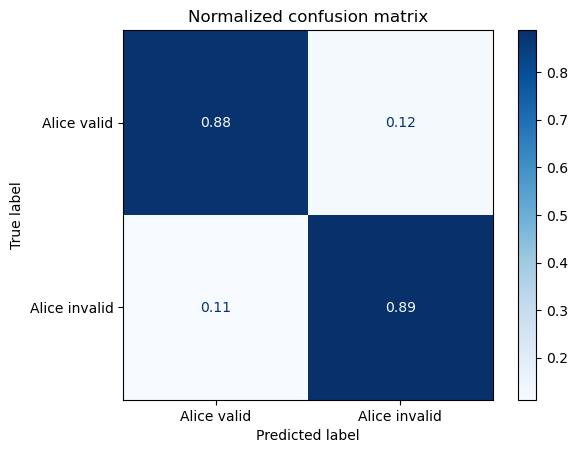

In [19]:
display.Image(home_directory+'/TFIDF_SVC_issued_patents_control'
              +'/tfidf_svc_poly2_confusion_matrix_issued_patents_control.jpg')

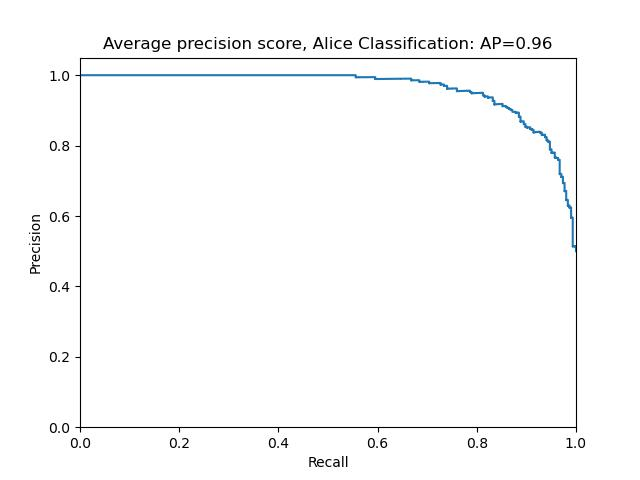

In [20]:
display.Image(home_directory+'/TFIDF_SVC_issued_patents_control'
              +'/tfidf_svc_poly2_precision_recall_curve_issued_patents_control.jpg')

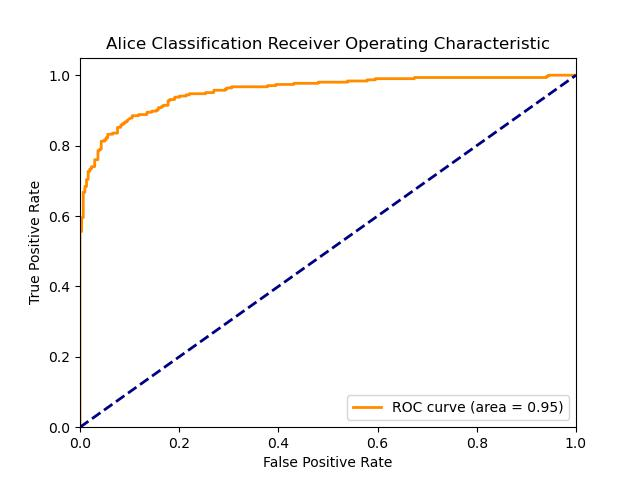

In [21]:
display.Image(home_directory+'/TFIDF_SVC_issued_patents_control'
              +'/tfidf_svc_poly2_ROC_curve_issued_patents_control.jpg')

Also the graphical analysis is very favorable of the model.

## 4) Classify patent claim texts of affected CPC groups

With the classification model now estimated, we can predict for exisiting patents whether they are affected based on their claim texts.  We can do this also for pre-grant application publications, which is implemented in a similar way in the module **application_pregrant_pub_claim_classification.py**.

In [22]:
from PyPatentAlice import patent_claim_classification

# Set module shared parameters in local namespace
patent_claim_classification.home_directory = home_directory
patent_claim_classification.PatentsView_directory = PatentsView_directory
patent_claim_classification.USPTO_data_directory = USPTO_data_directory
patent_claim_classification.RANDOM_SEED = RANDOM_SEED

I create a separete folder for the classification outcomes.  

For this example, I restrict to the classification of patents issued between two years before and two years after *Alice*.

In [23]:
# Define execution environment
output_directory = r'patent_classification'

# Create Output Path if not already exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# Output director for LIME data frames and word clouds
lime_output_directory = 'LIME_issued_patents_control'

# Create WC Output Path if not already exist
if not os.path.exists(lime_output_directory):
    os.makedirs(lime_output_directory)
    
    
# Load model
text_poly2_svc = joblib.load('TFIDF_SVC_issued_patents_control' 
                             + '//tfidf_svc_poly2_issued_patents_control.joblib')

# Patent issue year for which to classify patent texts
min_year_classification = 2012
max_year_classification = 2016

Since the training data already identify the most affected USPC classes, we can use application data from the USPTO to find the patent IDs of successful applications from these classes.  Specifically, we use the current USPC class data from PatentsView to identify affected patent IDs in the treated classes.  Since the USPTO stopped issuing USPC classes in 2013 but still used them for application, we can further expand the list of affected patents by loading a relatively recent vintage of Patent Examination Research Dataset (PatEx) application data that contains both USPC classes and patent IDs of succesful applications.

In [24]:
print('Find patents that fit the desired classes', flush=True)

#-------------------------------
# uspc_current classifications
#-------------------------------
uspc_current = pd.read_csv(PatentsView_directory + '/uspc_current_PatentsView.tsv', 
                           delimiter="\t", quoting=csv.QUOTE_NONNUMERIC, low_memory=False)

print('\t USPC Main Classes for classification: ' + str(uspc_main_category), flush=True)

#==============================================
# Find patents to investigate in affected USPC classes

# => Note that the loaded categories are in int
uspc_main_category_str = [str(c) for c in uspc_main_category]

uspc_current['mainclass_id'] = uspc_current['mainclass_id'].astype(str).\
    apply(lambda s: re.sub(r'^0*', '', str(s).split('.')[0]))

uspc_affected_patent = uspc_current[uspc_current.mainclass_id.isin(uspc_main_category_str)]
uspc_affected_patent = uspc_affected_patent[['patent_id', 'mainclass_id']].drop_duplicates()
uspc_affected_patent['patent_id'] = pd.to_numeric(uspc_affected_patent.patent_id,
                                                  downcast='integer', errors='coerce')

uspc_affected_patent_list = list(set(uspc_affected_patent.patent_id))

print('\t Number of identified patents to be classified from USPC classes: '
      + str(len(uspc_affected_patent_list)), flush=True)

#---------------------------------------------------------
print('\t Expand with patent ids from application data', flush=True)
# Append here the application data which contain a lot of uspc class information 
# to identify relevant applications for classifcation
#----------------------------------
# Application Data
#----------------------------------
application_data = pd.read_csv(USPTO_data_directory
                               + '/application_data_2020.csv', low_memory=False)

# Select the application with the fitting patent classes
application_data['uspc_class'] = application_data['uspc_class'].astype(str).\
    apply(lambda s: re.sub(r'^0*', '', str(s).split('.')[0]))

affected_applications = application_data[application_data.uspc_class.isin(uspc_main_category_str)]

# Coerce to integer, since focusing on utility patents
affected_applications['patent_id'] = pd.to_numeric(affected_applications.patent_number,
                                                   downcast='integer', errors='coerce')
uspc_affected_application_publication_list = list(set(affected_applications.patent_id))

# Expand patent list by patent ids from application data
uspc_affected_patent_list.extend(uspc_affected_application_publication_list)

print('\t Number of identified patents to be classified from USPC classes including application ids: '
      + str(len(uspc_affected_patent_list)), flush=True)

Find patents that fit the desired classes
	 USPC Main Classes for classification: ['434', '702', '705', '463']
	 Number of identified patents to be classified from USPC classes: 125074
	 Expand with patent ids from application data
	 Number of identified patents to be classified from USPC classes including application ids: 446693


Since most patents have now a CPC classification and there is not concordance table to translate USPC classification into CPC, we can use CPC data from PatentsView and the affected patents identified with the USPC classes to find the five most frequent CPC groups of affected patents.  These affected CPC groups cover around 50% of the affected patents based on USPC classes, but also are much broader and are available for more years.  Thus, there are around nine times as many patents in the affected CPC groups than in the USPC classes. 

In [25]:
# Note: most patents are now classified via CPC, as in Dugan (2018)
# Translate affected patents into CPC classes
# See: https://www.uspto.gov/patents-application-process/patent-search/classification-standards-and-development
#-------------------------------
# cpc classifications
#-------------------------------
cpc_current = pd.read_csv(PatentsView_directory + '/cpc_current_PatentsView.tsv', 
                            delimiter="\t", quoting=csv.QUOTE_NONNUMERIC, low_memory=False)
#-------------------------------------
# Focus on primary categories
cpc_current = cpc_current[cpc_current.cpc_type=='inventional']

# Drop unneeded columns and make cpc groups unique
cpc_current = cpc_current.drop(['cpc_section',
                                'cpc_type',
                                'cpc_class', 
                                'cpc_group',
                                'cpc_sequence'], axis=1).drop_duplicates().\
    rename(columns={'cpc_subclass':'group_id'})

# Cast id to int
cpc_current['patent_id'] = pd.to_numeric(cpc_current.patent_id,
                                         downcast='integer', errors='coerce')

#-------------------------------------
# Find patent_ids in the CPC data for the affected USPC classes
cpc_uspc_patents = cpc_current[cpc_current.patent_id.isin(
    [s for s in uspc_affected_patent_list if not(np.isnan(s))])]

# select the five most common cpc classes
main_cpc_classes = list(set(cpc_uspc_patents.group_id.value_counts(). \
                            nlargest(5).reset_index()['index']))

print('\t Most frequent CPC classes\n' 
      + str(cpc_uspc_patents.group_id.value_counts(normalize=True).head(10).cumsum()), flush=True)

print('\t Selected main CPC classes\n' + str(main_cpc_classes), flush=True)

# Define as patent ids those patents within the respective main CPC classes
cpc_affected_patent_list = list(cpc_current[cpc_current.group_id.isin(main_cpc_classes)]['patent_id'])
print('\t Number of affected cpc based patents: ' + str(len(cpc_affected_patent_list)), flush=True)

del cpc_current, uspc_current

	 Most frequent CPC classes
G06Q    0.246416
G06F    0.336639
G07F    0.403169
A63F    0.451186
H04L    0.495192
G09B    0.531846
G16H    0.559811
G01R    0.586250
G01N    0.610810
H04N    0.626473
Name: group_id, dtype: float64
	 Selected main CPC classes
['G06F', 'G07F', 'A63F', 'H04L', 'G06Q']
	 Number of affected cpc based patents: 1527320


Using the lost of patents in affected USPC classes, we can now iterate through the claim text by publication year in PatentsView and use the trained model to predict for each independent claim text whether it is affected or not. The classification method could also be run parallel for larger samples.  Either way, the annual results are aggregated to one dataframe with claim-level treatment predictions.  

Here, the SVC classification based on the TF-IDF text vector representation with polynomial kernel of degree two performs best.  The model also give a predicted probability for treatment.  

In [26]:
print('Classification for patents that are in relevant USPC classes', flush=True)

# Define result storage df
text_poly2_svc_classification_uspc = pd.DataFrame()

#-----------------------------------
# Create sub-director for extracted texts to be classified
suboutput_dir = output_directory+'//uspcAffected__TFIDF_poly2_issued_patents_control'
if not os.path.exists(suboutput_dir):
    os.makedirs(suboutput_dir)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Linear Execution
for year in range(min_year_classification, max_year_classification+1):
    print('\tAffected patents in uspc classes for issue year: ' + str(year) + '\n')
    patent_claim_classification.patent_claim_classification_PatentView(
        year=year,
        affected_patent_list=uspc_affected_patent_list,
        nlp_model=text_poly2_svc,
        output_path=suboutput_dir)

Classification for patents that are in relevant USPC classes
	Affected patents in uspc classes for issue year: 2012

	 Search treated patent claims for year 2012
	 Lenght of output DF of classified independent claims for year 2012: 35710
	Affected patents in uspc classes for issue year: 2013

	 Search treated patent claims for year 2013
	 Lenght of output DF of classified independent claims for year 2013: 39512
	Affected patents in uspc classes for issue year: 2014

	 Search treated patent claims for year 2014
	 Lenght of output DF of classified independent claims for year 2014: 37173
	Affected patents in uspc classes for issue year: 2015

	 Search treated patent claims for year 2015
	 Lenght of output DF of classified independent claims for year 2015: 18544
	Affected patents in uspc classes for issue year: 2016

	 Search treated patent claims for year 2016
	 Lenght of output DF of classified independent claims for year 2016: 14135


In [27]:
# Load from Target
patent_classification_files = os.listdir(suboutput_dir)
patent_classification_path = [suboutput_dir+'//'+f for f in patent_classification_files if \
                              bool(re.search('.csv', f)) & bool(re.search('FullText', f)) & \
                                  bool(re.search('patentClaim', f))  & \
                                      bool(re.search(r'\d{4,4}', f))]

for load_file in patent_classification_path:
    append_df = pd.read_csv(load_file, encoding='utf-8', low_memory=False)
    append_df['year'] = re.search(r'\d{4,4}', load_file).group(0)

    text_poly2_svc_classification_uspc = pd.concat(
        [text_poly2_svc_classification_uspc,
         append_df],
        axis=0)

In [28]:
# Save Fulltext output
text_poly2_svc_classification_uspc.to_csv(
    path_or_buf = output_directory +
    '/FullText_patents_uspcAffected__predicted__TFIDF_poly2_issued_patents_control.csv', 
    index=False, encoding = 'utf-8')

print('\t\t Total length of classified patent claims - affected USPC based; TFIDF + SVC Poly 2: ' +
      str(len(text_poly2_svc_classification_uspc)), flush=True)
print('\t\t Unique classified patents - affeced USPC based; SVC Poly 2: ' +
      str(len(text_poly2_svc_classification_uspc.patent_id.unique())), flush=True)

		 Total length of classified patent claims - affected USPC based; TFIDF + SVC Poly 2: 145074
		 Unique classified patents - affeced USPC based; SVC Poly 2: 49851


Similarly to above, we can classify claim texts of patents in affected CPC groups.  

In [29]:
# Repeat process for patent identified using CPC groups
print('Classification for patents that are in relevant CPC groups', flush=True)

# Define result storage df
text_poly2_svc_classification_cpc = pd.DataFrame()

#-----------------------------------
# Create sub-director for extracted texts to be classified
suboutput_dir = output_directory+'//cpcAffected__TFIDF_poly2_issued_patents_control'
if not os.path.exists(suboutput_dir):
    os.makedirs(suboutput_dir)


#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Linear Execution
for year in range(min_year_classification, max_year_classification+1):
    print('\tAffected patents in cpc group for issue year: ' + str(year) + '\n')
    patent_claim_classification.patent_claim_classification_PatentView(
        year,
        cpc_affected_patent_list,
        text_poly2_svc,
        suboutput_dir)

Classification for patents that are in relevant CPC groups
	Affected patents in cpc group for issue year: 2012

	 Search treated patent claims for year 2012
	 Lenght of output DF of classified independent claims for year 2012: 172503
	Affected patents in cpc group for issue year: 2013

	 Search treated patent claims for year 2013
	 Lenght of output DF of classified independent claims for year 2013: 193996
	Affected patents in cpc group for issue year: 2014

	 Search treated patent claims for year 2014
	 Lenght of output DF of classified independent claims for year 2014: 216500
	Affected patents in cpc group for issue year: 2015

	 Search treated patent claims for year 2015
	 Lenght of output DF of classified independent claims for year 2015: 207249
	Affected patents in cpc group for issue year: 2016

	 Search treated patent claims for year 2016
	 Lenght of output DF of classified independent claims for year 2016: 210895


In [30]:
# Load from Target
patent_classification_files = os.listdir(suboutput_dir)
patent_classification_path = [suboutput_dir+'//'+f for f in patent_classification_files if \
                              bool(re.search('.csv', f)) & bool(re.search('FullText', f)) & \
                                bool(re.search('patentClaim', f)) & \
                                      bool(re.search(r'\d{4,4}', f))]

for load_file in patent_classification_path:
    append_df = pd.read_csv(load_file, encoding='utf-8', low_memory=False)
    append_df['year'] = re.search(r'\d{4,4}', load_file).group(0)

    text_poly2_svc_classification_cpc = pd.concat(
        [text_poly2_svc_classification_cpc,
         append_df],
        axis=0)

In [31]:
# Save Fulltext output
text_poly2_svc_classification_cpc.to_csv(
    path_or_buf = output_directory +
    '/FullText__patents_cpcAffected__predicted__TFIDF_poly2_issued_patents_control.csv', 
    index=False, encoding = 'utf-8')

print('\t\t Total length of classified patent claims - affected CPC based; TFIDF + SVC Poly 2: ' +
      str(len(text_poly2_svc_classification_cpc)), flush=True)
print('\t\t Unique classified patents - affected CPC based; SVC Poly 2: ' +
      str(len(text_poly2_svc_classification_cpc.patent_id.unique())), flush=True)

		 Total length of classified patent claims - affected CPC based; TFIDF + SVC Poly 2: 1001143
		 Unique classified patents - affected CPC based; SVC Poly 2: 327230


For the classified patents, we can now create also word clouds comparing predicted treated and predicted valid claim texts.  Since we have so many patent in affected CPC groups, we can just restrict to a sample of one million claims.

In [32]:
print('Create Word Clouds for predicted patent classes', flush=True)

model_data_text_poly2_svc_uspc = text_poly2_svc_classification_uspc[
    ['claim_text', '1', 'predicted_label']
    ].drop_duplicates()

# Create model text for word cloud and predict classification
model_data_text_poly2_svc_uspc = model_data_text_poly2_svc_uspc.rename(
    columns={'1':'pred_treated'})

model_data_text_poly2_svc_uspc['treated'] = (model_data_text_poly2_svc_uspc.\
                                             predicted_label == 1).astype(int)

patent_claim_classification.wordcloud_creation(
    model_data=model_data_text_poly2_svc_uspc,
    output_directory=output_directory,
    version_string='patents_uspcAffected__TFIDF_poly2_issued_patents_control')

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
model_data_text_poly2_svc_cpc = text_poly2_svc_classification_cpc[
    ['claim_text', '1', 'predicted_label']
    ].drop_duplicates()

# Create model text for word cloud and predict classification
model_data_text_poly2_svc_cpc = model_data_text_poly2_svc_cpc.rename(columns={'1':'pred_treated'})

model_data_text_poly2_svc_cpc['treated'] = (model_data_text_poly2_svc_cpc.predicted_label == 1).\
    astype(int)

# There are vastly more cpc classifications than uspc classification => randomly draw! if size over 1M
if len(model_data_text_poly2_svc_cpc) > 1000000:
    model_data_text_poly2_svc_cpc = model_data_text_poly2_svc_cpc.sample(
        n=1000000,
        random_state = RANDOM_SEED,
        replace=False)

patent_claim_classification.wordcloud_creation(
    model_data=model_data_text_poly2_svc_cpc,
    output_directory=output_directory,
    version_string='patents_cpcAffected__TFIDF_poly2_issued_patents_control')

Create Word Clouds for predicted patent classes


Comparing the terms that are relatively more frequent in treated versus valid claims, we see that valid claims contain more diverse words including specifications of physical implementations while invalid claims feature abstract descriptions about business processes such as computer-based methods.  This is in line with the Supreme Court ruling that abstract claims are not patent eligible.

More frequent terms in invalid claims after Alice


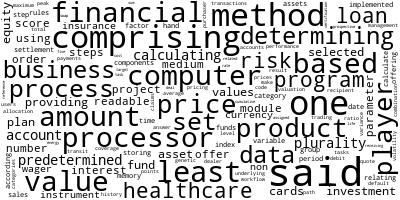

In [33]:
print('More frequent terms in invalid claims after Alice')
display.Image(home_directory+'/Wordcloud_issued_patents_control'
              +'/wc_differential_frequency_weighting_treated_trainingData_issued_patents_control.jpg')

More frequent terms in valid claims


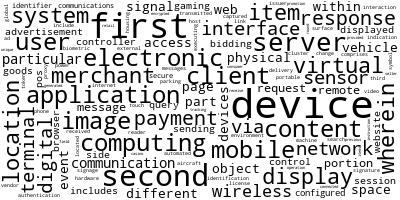

In [34]:
print('More frequent terms in valid claims')
display.Image(home_directory+'/Wordcloud_issued_patents_control'
              +'/wc_differential_frequency_weighting_untreated_trainingData_issued_patents_control.jpg')

To better understand what words more most relevant for the classification as valid or invalid, we can apply the local interpretable model-agnostic explanations (LIME) method to the trained model and the two classification outcomes for USPC classes and CPC groups.  Also here, the methods will create word clouds that visualize the most relevant word for the classification as treated or valid.

In [35]:
print('Lime classification sample analysis', flush=True)

_, top_label_df_grouped_poly2_svc_uspc =  patent_claim_classification.lime_text_explainer(
    patent_classification=text_poly2_svc_classification_uspc[
        ['claim_text', '1', 'predicted_label']
        ].drop_duplicates(),
    model=text_poly2_svc,
    output_path=lime_output_directory,
    version_string='patents_uspcAffected__TFIDF_poly2_issued_patents_control',
    size=100)

patent_claim_classification.wordcloud_top_label_df(
    top_label_df_grouped=top_label_df_grouped_poly2_svc_uspc,
    output_directory=lime_output_directory,
    version_string='patents_uspcAffected__TFIDF_poly2_issued_patents_control')

Lime classification sample analysis


In [36]:
_, top_label_df_grouped_poly2_svc_cpc =  patent_claim_classification.lime_text_explainer(
    patent_classification=text_poly2_svc_classification_cpc[
        ['claim_text', '1', 'predicted_label']
        ].drop_duplicates(),
    model=text_poly2_svc,
    output_path=lime_output_directory,
    version_string='patents_cpcAffected__TFIDF_poly2_issued_patents_control',
    size=100)

patent_claim_classification.wordcloud_top_label_df(
    top_label_df_grouped=top_label_df_grouped_poly2_svc_cpc,
    output_directory=lime_output_directory,
    version_string='patents_cpcAffected__TFIDF_poly2_issued_patents_control')

When we visualzie the results of the LIME method, we can confirm that the model is more likely to predict that a claim is invalid if it contains more abstract and general terms like 'method', while claims that include more concrete language on the implementation of software innovations, like 'device' or 'control', are more likely to be classified as valid.

Terms most relevant for classifying claim as invalid


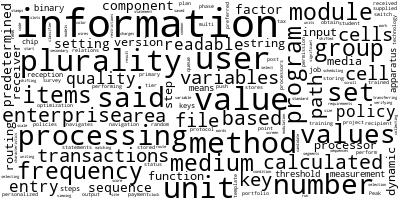

In [37]:
print('Terms most relevant for classifying claim as invalid')
display.Image(home_directory
              + '//LIME_issued_patents_control'
              + '//wc_lime_top_words_treated_claims_patents_cpcAffected__TFIDF_poly2_issued_patents_control.jpg')

Terms most relevant for classifying claim as valid


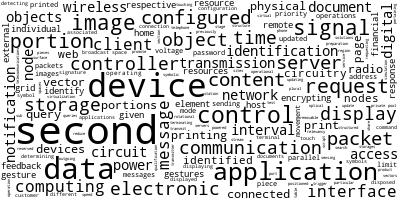

In [38]:
print('Terms most relevant for classifying claim as valid')
display.Image(home_directory
              + '//LIME_issued_patents_control'
              + '//wc_lime_top_words_untreated_claims_patents_cpcAffected__TFIDF_poly2_issued_patents_control.jpg')

In [39]:
# Clean up some memory before executing next step
del text_poly2_svc_classification_cpc, text_poly2_svc_classification_uspc

## 5) Test of the classification outcome

By now, we finally have claim-level predictions for whether a text is valid or invalid under *Alice*.  To verify that this classification is meaningful, I compare the counts of patents that are predicted to valid or invalid on quarterly basis for each affected CPC group.  If my model performs better than using CPC groups alone, I would expect to see a significantly larger decline in issued patents that are predicted to be invalid compared to patents that are predicted to be valid.

In [40]:
from PyPatentAlice import classification_testing

# Set module shared parameters in local namespace
classification_testing.home_directory = home_directory
classification_testing.PatentsView_directory = PatentsView_directory
classification_testing.USPTO_data_directory = USPTO_data_directory
classification_testing.RANDOM_SEED = RANDOM_SEED

The method in build a basic data frame that load issue dates and CPC groups from PatentsView and defines a patent as treated if it's first claim is classified as invalid.  The first claim of a patent is usually the most important and broadest claim of a patent and thus defines the scope of the patent.

I then count the number of predicted valid and invalid patents by CPC group and issue quarter.  The post period after the intervention start after the *Alice* decision.

Since we have somewhat large differences in the number of quarterly patent issuances, I normalize each quarterly count by the its first value in Q1 2012.  Thus, every count starts at one and we can more easily compare how the relative number of issuance change over time.

In [41]:
# Load patent-level classification outcomes
df = classification_testing.analysis_df_build()

# Aggregate to CPC group - quarter - treatment counts
agg_counts = df.groupby(
    ['group_id', 'quarter_issue_date_dt', 'Treated'])['patent_id'].\
    count().reset_index().rename(columns={'patent_id':'Count'})

alice_decision_date = np.datetime64('2014-06-19')
agg_counts['Post'] = (agg_counts['quarter_issue_date_dt'] > alice_decision_date).astype(int)


# Normalize the count 1 at the beginning of 2012
norm_counts = agg_counts[
    ['group_id', 'quarter_issue_date_dt', 'Treated', 'Count']].\
    sort_values('quarter_issue_date_dt')

first = (norm_counts.drop('quarter_issue_date_dt', axis=1).\
         groupby(['group_id', 'Treated']).transform('first'))
norm_counts['normalized_Count'] = norm_counts['Count'] / first['Count']

Load PatentsView patent and current CPC data
Load Alice classification outcomes and define treated patents
Merge and output patent and classification data


Plotting the two time series for the quartlery issuances by CPC group, we can clearly see that after the *Alice* decision treated patent issuances fell much more than issuances of patents that are predicted to be valid.  Indeed, even within CPC groups, my model can identify valid from invalid patents under *Alice*.

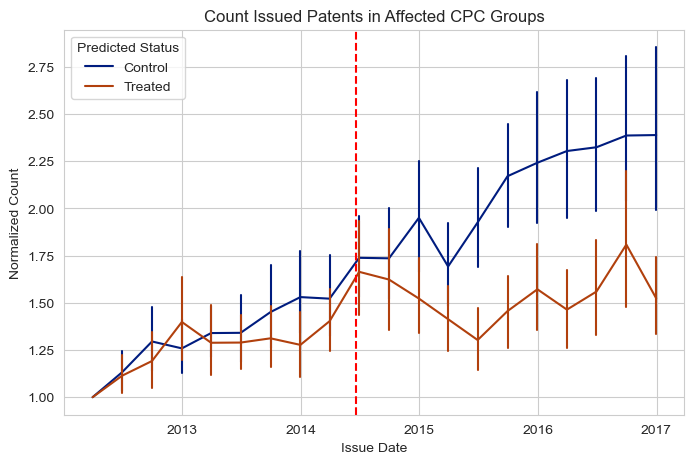

In [42]:
sns.set_style("whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8, 5))
ax = sns.lineplot(data=norm_counts,
                    y='normalized_Count',
                    x='quarter_issue_date_dt',
                    hue='Treated',
                    markers=True,
                    err_style='bars',
                    errorbar='ci')

ax.axvline(x = alice_decision_date.__hash__(),
           color='r', linestyle='--') 
ax.set(xlabel='Issue Date', 
       ylabel='Normalized Count',
       title='Count Issued Patents in Affected CPC Groups')

plt.legend(title = 'Predicted Status', loc='upper left', labels=['Control', 'Treated'])
plt.show()

The graphic includes confidence interval around each point estimate.  Consistent with what we would expect, patent issuances of treated and control patents follow the same trend before *Alice*, with no significant pre-trend difference for treated patents.  After *Alice*, the number of issued treated patents significantly decreases relative to the control patents, which show broadly a continuation of the pre-*Alice* trend.  

Next, we can quanity the drop in invalid patent issuances compared to valid issuances by running variations of difference-in-differences modes with treatment defined by being classified as invalid and the post-period starting after the *Alice* decision.  

For the first model, we can just run a simple OLS regression.  I take the log of the issuance counts so that the coefficients can be interpreted as percentage changes and to limit the effect of outliers with large quarterly patent issuances.  Standard error are clustered on the CPC group level.

In [43]:
# Regression models

# Log is useful to estimate percentage changes
agg_counts['log_Count'] = np.log(agg_counts['Count'])

reg_did = sm.ols(formula='log_Count ~ Treated * Post',
                 data=agg_counts).fit(
                     cov_type='cluster',
                     cov_kwds={'groups': agg_counts['group_id']})
print(reg_did.summary())    

                            OLS Regression Results                            
Dep. Variable:              log_Count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.089
Date:                Sat, 28 Oct 2023   Prob (F-statistic):            0.00181
Time:                        00:41:36   Log-Likelihood:                -9743.5
No. Observations:                5029   AIC:                         1.949e+04
Df Residuals:                    5025   BIC:                         1.952e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4040      0.123     11.399   

The coefficient of the difference-in-differences model shows that patent issuances for patents that are predicted to be invalid by the model decrease by ca. 12.5% after the *Alice* decision, even compared to patents in the same CPC group.  Thus, my classification model is significanly better at identifying invalid patents than the technology classification by the USPTO alone.


While this appears like a rather small shock, it should be noted that this decrease happens across a very large set of patents (in this example alone we classified more than one million patents), thus a shortfall of 12.5% translates into thousands of innovations that are not patent eligible anymore.  

We can expand on the simple OLS setting and control for CPC group and quarter fixed effects in a panel model.

In [44]:
panel_df = agg_counts.copy()
panel_df = panel_df.set_index(['group_id', 'quarter_issue_date_dt'])
reg_fe = PanelOLS.from_formula(
    formula='log_Count ~ Treated * Post + EntityEffects + TimeEffects',
    data=panel_df, drop_absorbed=True).fit(
            cov_type='clustered', cluster_entity=True, cluster_time=False)
print(reg_fe)    

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_Count   R-squared:                        0.4544
Estimator:                   PanelOLS   R-squared (Between):             -0.4337
No. Observations:                5029   R-squared (Within):               0.4223
Date:                Sat, Oct 28 2023   R-squared (Overall):             -0.2687
Time:                        00:41:36   Log-likelihood                   -3995.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1917.7
Entities:                         403   P-value                           0.0000
Avg Obs:                       12.479   Distribution:                  F(2,4605)
Min Obs:                       1.0000                                           
Max Obs:                       40.000   F-statistic (robust):             146.79
                            

Including fixed effects improves the fit substantially and shows an even larger and more significant decline of 14.2% for patent issuances predicted to be invalid by my model.

Since patent counts are discrete (and log transformations are problematic for discrete variables), I also implement two count models for the difference-in-differences estimation: a Poisson regression and a Negative Binomial model.

In [45]:
reg_poisson = poisson(formula='Count ~ Treated * Post',
                      data=agg_counts).fit()
reg_negbin = negativebinomial(formula='Count ~ Treated * Post',
                              data=agg_counts).fit()

print(reg_poisson.summary())

Optimization terminated successfully.
         Current function value: 193.853419
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.006342
         Iterations: 4
         Function evaluations: 22
         Gradient evaluations: 19
                          Poisson Regression Results                          
Dep. Variable:                  Count   No. Observations:                 5029
Model:                        Poisson   Df Residuals:                     5025
Method:                           MLE   Df Model:                            3
Date:                Sat, 28 Oct 2023   Pseudo R-squ.:                 0.01710
Time:                        00:41:36   Log-Likelihood:            -9.7489e+05
converged:                       True   LL-Null:                   -9.9185e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
------------

In [46]:
print(reg_negbin.summary())

                     NegativeBinomial Regression Results                      
Dep. Variable:                  Count   No. Observations:                 5029
Model:               NegativeBinomial   Df Residuals:                     5025
Method:                           MLE   Df Model:                            3
Date:                Sat, 28 Oct 2023   Pseudo R-squ.:                0.003634
Time:                        00:41:37   Log-Likelihood:                -20148.
converged:                       True   LL-Null:                       -20221.
Covariance Type:            nonrobust   LLR p-value:                 1.196e-31
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3055      0.053     80.518      0.000       4.201       4.410
Treated         -0.6146      0.095     -6.477      0.000      -0.801      -0.429
Post             0.0915      0.070      1.31

Looking at the outcome for the count model, we see that the coefficient for the difference-in-differences interaction terms shows that count of invalid patents decreases by ca. 1-exp(-0.27)=23.7% after *Alice* relativ to valid patents.  Thus, the effect of *Alice* and the performance of the model are even more pronounced when taking into account the discrete distribution of the outcome variable.  

Consistent across all estimations, we find that the count of treated patents decreased following the *Alice* decision relative to the count of patents that are predicted to be valid.  Even within CPC groups that are most affected by *Alice*, the classification method identifies invalid patents consistently.

In [ ]:
# Save sample data
    agg_counts.to_csv('example_data_for_analysis.csv', index=False)
    df.to_csv('example_data_classified_patents.csv', index=False)
    
    # Load Alice patent classification
    patent_classification_df = pd.read_csv(
        'patent_classification' 
        + '/FullText__patents_cpcAffected__predicted__TFIDF_poly2_issued_patents_control.csv', 
        usecols=['patent_id', 'claim_sequence', '0', '1', 'predicted_label'],
        low_memory=False)

    
    patent_classification_df.to_csv('example_data_claim_classification.csv', index=False)